# Dependências

In [1]:
#Importando bibliotecas
import warnings 
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from yellowbrick.model_selection import LearningCurve
from dependencias.modelagem_metricas import conveter_OnePre,conveter_EMP_Sat_Remote,conveter_EMP_Engagement,\
                                   conveter_Emp_Work_Status,conveter_Emp_Competitive,\
                                   conveter_Emp_Collaborative,preencher_missing_0, plot_metrics,\
                                   eval_thresh, naive_classifiers
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
#Constantes
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_INTER_PATH = os.path.join('..','data','inter') 
DATA_INTER_TRAIN_A1 = 'train_inter_a1.csv'
DATA_INTER_TRAIN_A2 = 'train_inter_a2.csv'
DATA_INTER_TEST = 'test_inter.csv'
MODEL_PATH = os.path.join('..','models')
MODEL_NAME = 'modelo_demissao.pkl'
IMG_PATH = os.path.abspath(os.path.join('..','img'))
META_DATA_PATH_INTER = os.path.join(DATA_INTER_PATH,'dicionario_tipos_inter.pkl')

In [3]:
# Dados do dicionário salvo no pickle.
with open(META_DATA_PATH_INTER,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)

In [4]:
# Dados que serão utilizados na modelagem (Com as features selecionadas da primeira abordagem: 
#Correlação + Chi2+ Boruta).
df_train_A1 = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_A1),dtype=dicionario_tipo)

In [5]:
# Dados que serão utilizados na modelagem (Com as features selecionadas da primeira abordagem: Boruta)
df_train_A2 = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_A2),dtype=dicionario_tipo)

In [6]:
df_test = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TEST),dtype=dicionario_tipo)

In [7]:
df_test.shape

(3000, 50)

In [8]:
df_train_A2.shape

(11999, 20)

In [9]:
df_train_A1.shape

(11999, 16)

## Média das avaliações para os dados de teste. 

In [10]:
#Média da avaliação One Pre
df_test = conveter_OnePre(df_test)
#Média da avaliação Remote
df_test = conveter_EMP_Sat_Remote(df_test)
#Média da avaliação de Engagement
df_test = conveter_EMP_Engagement(df_test)
##Média da avaliação Work
df_test = conveter_Emp_Work_Status(df_test)
#Média da avaliação Competitive
df_test = conveter_Emp_Competitive(df_test)
#Média da avaliaçãi Collaborative. 
df_test = conveter_Emp_Collaborative(df_test)

## Preenchimento de missing das variáveis de teste

In [11]:
df_test = preencher_missing_0(df_test)

In [12]:
df_train_A1.shape

(11999, 16)

# Criando Pipeline

## Pipe para df_train_A1

In [13]:
#Tratando as variaveis  
variaveis_categoricas_A1 = df_train_A1.select_dtypes(include=['object']).columns.tolist()
variaveis_numericas_A1 = df_train_A1.select_dtypes(include=['int','float']).columns.tolist()

In [14]:
target_A1 = 'left_Company'
variaveis_categoricas_A1.remove(target_A1)

In [15]:
pipeline_numerico_A1 = Pipeline([('impute', SimpleImputer(strategy='median'))])
pipeline_categorico_A1 = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                         ('ordinal_encoder', OrdinalEncoder())])

In [16]:
variaveis_categoricas_A1

['salary', 'Work_accident']

In [17]:
variaveis_numericas_A1

['EMP_Sat_OnPrem_mean',
 'Emp_Identity',
 'Emp_Position',
 'number_project',
 'EMP_Engagement_mean',
 'Sensor_Heartbeat(Average/Min)',
 'average_montly_hours',
 'Emp_Role',
 'time_spend_company',
 'Emp_Title',
 'EMP_Sat_Remote_mean',
 'Emp_Competitive_mean',
 'Sensor_StepCount']

In [18]:
preprocess_pipeline_A1 = ColumnTransformer([('pipe_categorico', pipeline_categorico_A1, variaveis_categoricas_A1),
                                ('pipe_numerico', pipeline_numerico_A1 , variaveis_numericas_A1)])

In [19]:
# Definindo folds para a validação cruzada estratificada (dados desbalanceados)
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)

## df_train_A2

In [20]:
#Tratando as variaveis  
variaveis_categoricas_A2 = df_train_A2.select_dtypes(include=['object']).columns.tolist()
variaveis_numericas_A2 = df_train_A2.select_dtypes(include=['int','float']).columns.tolist()

In [21]:
target_A2 = 'left_Company'
variaveis_categoricas_A2.remove(target_A2)

In [22]:
pipeline_numerico_A2 = Pipeline([('impute', SimpleImputer(strategy='median'))])
pipeline_categorico_A2 = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                         ('ordinal_encoder', OrdinalEncoder())])

In [23]:
preprocess_pipeline_A2 = ColumnTransformer([('pipe_categorico', pipeline_categorico_A2, variaveis_categoricas_A2),
                                ('pipe_numerico', pipeline_numerico_A2 , variaveis_numericas_A2)])

In [24]:
variaveis_categoricas_A2

['promotion_last_5years', 'Work_accident']

In [25]:
len(variaveis_numericas_A2)

17

# Modelagem e Avaliação

In [26]:
rf = RandomForestClassifier(random_state=0)

Vou basear a análise do modelo no recall, pois os Falsos Negativos (pessoas que o modelo disse que não se demitiram, mas que na verdade se demitiram) parecem ser mais danosos para a empresa. A escolha da métrica de avaliação, porém, é um passo importante do pipeline de modelagem e deve ser ajustada de acordo com as necessidades levantadas pelo cliente. Pode até mesmo ser uma métrica personalizada.

## df_train_A1

In [27]:
modelo_pipe_A1  =  Pipeline(steps = [('preprocessor',preprocess_pipeline_A1),
                                  ('model',rf)])

In [28]:
# Obtendo X e Y para treinamento e teste
X_A1 = df_train_A1.drop(target_A1,axis=1)
y_A1 = df_train_A1[target_A1]
X_A1_test = df_test.drop(target_A1, axis=1)
y_A1_test = df_test[target_A1]
#Convertendo o target para inteiro/treino.
y_A1 = y_A1.apply(lambda x: int(x))
#Convertendo o target para inteiro/teste.
y_A1_test = df_test[target_A1].apply(lambda x: int(x))

In [29]:
df_test.shape

(3000, 28)

In [30]:
# Score de Validação Cruzada
cross_validation_results_A1 = cross_val_score(modelo_pipe_A1,X_A1,y_A1, scoring = 'recall')
print(f'A média de validação cruzada foi: {round(np.mean(cross_validation_results_A1),2)}\nO desvio padrão de validação cruzada foi: {round(np.std(cross_validation_results_A1),2)}')

A média de validação cruzada foi: 1.0
O desvio padrão de validação cruzada foi: 0.0


In [31]:
X_A1

,EMP_Sat_OnPrem_mean,Emp_Identity,Emp_Position,number_project,EMP_Engagement_mean,Sensor_Heartbeat(Average/Min),average_montly_hours,Emp_Role,time_spend_company,Emp_Title,EMP_Sat_Remote_mean,Emp_Competitive_mean,Sensor_StepCount,salary,Work_accident
0,1.8,1,1,5,4.2,78,234,1,2,2,4.2,3.0,2548,medium,1
1,3.5,2,2,5,1.8,85,265,2,5,1,4.2,3.0,1514,medium,0
2,3.5,2,3,3,4.2,70,137,4,5,2,4.2,2.4,4980,low,0
3,3.5,3,3,5,4.2,78,222,3,2,2,4.2,2.4,5953,low,0
4,3.5,2,3,5,4.2,80,232,3,4,3,4.2,2.8,5447,low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,3.5,4,3,3,4.2,72,139,2,2,3,4.2,3.2,5958,medium,0
11995,3.5,3,2,4,4.2,78,177,4,2,2,4.2,2.6,5599,high,0
11996,3.8,1,1,2,1.8,74,135,1,3,1,2.4,1.6,1734,low,0
11997,3.5,2,4,5,4.2,72,199,2,4,4,4.2,3.6,5362,medium,0


In [32]:
# treinando
modelo_pipe_A1.fit(X_A1, y_A1)
#Predict_proba para classe 1 - Treinamento.
y_proba_A1 = modelo_pipe_A1.predict_proba(X_A1)[:,1]
#Previsões para o teste.
y_proba_A1_test = modelo_pipe_A1.predict_proba(X_A1_test)[:,1]

In [33]:
#Variando Threshold para avaliar Recall Precision e f1_score do treino.
df_metrics_train_A1 = eval_thresh(y_real = y_A1, y_proba = y_proba_A1)
#Variando Threshold para avaliar Recall Precision e f1_score do teste.
df_metrics_test_A1 = eval_thresh(y_real = y_A1_test, y_proba = y_proba_A1_test)

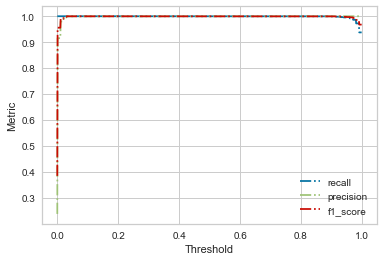

<Figure size 432x288 with 0 Axes>

In [34]:
##plot das métricas que estão no dataframe df (métricas vs thresholds), dos dados de treino A1 
plot_metrics(df_metrics_train_A1)
plt.savefig(os.path.join(IMG_PATH,'metrica_vs_thesholds_treino_A1.png'), format='png')

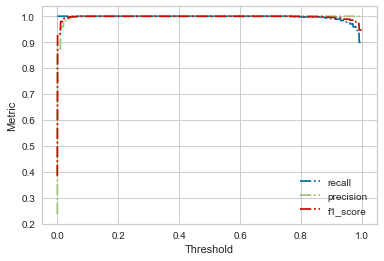

In [35]:
#plot das métricas que estão no dataframe df (métricas vs thresholds), dos dados de teste A1.
plt.savefig(os.path.join(IMG_PATH,'metrica_vs_thesholds_teste_A1.png'), format='png')
plot_metrics(df_metrics_test_A1)

In [36]:
print('Resultados para o Teste\n')
print(classification_report(y_A1_test, modelo_pipe_A1.predict(X_A1_test)))

Resultados para o Teste

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2286
           1       1.00      1.00      1.00       714

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [37]:
print('Resultados para o Treino\n')
print(classification_report(y_A1, modelo_pipe_A1.predict(X_A1)))

Resultados para o Treino

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



## df_train_A2

In [38]:
modelo_pipe_A2  =  Pipeline(steps = [('preprocessor',preprocess_pipeline_A2),
                                  ('model',rf)])

In [39]:
# Obtendo X e Y para treinamento e teste
X_A2 = df_train_A2.drop(target_A2,axis=1)
y_A2 = df_train_A2[target_A2]
X_A2_test = df_test.drop(target_A2, axis=1)
y_A2_test = df_test[target_A2]
#Convertendo o target para inteiro/treino.
y_A2 = y_A2.apply(lambda x: int(x))
#Convertendo o target para inteiro/teste.
y_A2_test = y_A2_test.apply(lambda x: int(x))

In [40]:
# Score de Validação Cruzada
cross_validation_results_A2 = cross_val_score(modelo_pipe_A2,X_A2,y_A2, scoring = 'recall')
print(f'A média de validação cruzada foi: {round(np.mean(cross_validation_results_A2),2)}\nO desvio padrão de validação cruzada foi: {round(np.std(cross_validation_results_A2),2)}')

A média de validação cruzada foi: 1.0
O desvio padrão de validação cruzada foi: 0.0


In [41]:
modelo_pipe_A2.fit(X_A2,y_A2)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipe_categorico',
                                                  Pipeline(memory=None,
                                                           steps=[('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                           

In [42]:
#Predict_proba para classe 1 - Treinamento.
y_proba_A2 = modelo_pipe_A2.predict_proba(X_A2)[:,1]
y_proba_A2_test = modelo_pipe_A2.predict_proba(X_A2_test)

In [43]:
#Variando Threshold para avaliar Recall Precision e f1_score do treino.
df_metrics_train_A2 = eval_thresh(y_real = y_A2, y_proba = y_proba_A2)
#Variando Threshold para avaliar Recall Precision e f1_score do teste.
df_metrics_test_A2 = eval_thresh(y_real = y_A2_test, y_proba = y_proba_A2_test[:,1])

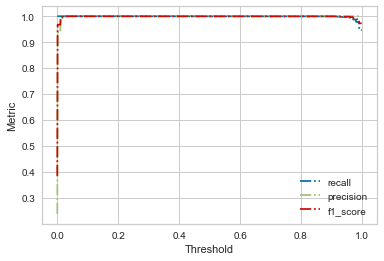

<Figure size 432x288 with 0 Axes>

In [44]:
#plot das métricas que estão no dataframe df (métricas vs thresholds), dos dados de treino A2.
plot_metrics(df_metrics_train_A2)
plt.savefig(os.path.join(IMG_PATH,'metrica_vs_thesholds_traino_A2.png'), format='png')

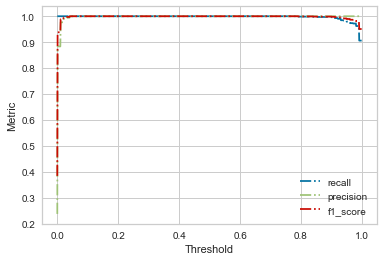

<Figure size 432x288 with 0 Axes>

In [45]:
##plot das métricas que estão no dataframe df (métricas vs thresholds), dos dados de teste A2. 
plot_metrics(df_metrics_test_A2)
plt.savefig(os.path.join(IMG_PATH,'metrica_vs_thesholds_teste_A2.png'), format='png')

In [46]:
print(classification_report(y_A2, modelo_pipe_A2.predict(X_A2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



In [47]:
print(classification_report(y_A2_test, modelo_pipe_A2.predict(X_A2_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2286
           1       1.00      1.00      1.00       714

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



## Classificadores Naive

In [48]:
# Dados da abordagem 1
df_test[target_A1] = df_test[target_A1].astype('int')
df_train_A1[target_A1] = df_train_A1[target_A1].astype('int')

In [49]:
df_naive_A1 = naive_classifiers(df_train_A1, df_test, target = target_A1)
df_naive_A1

,constant,most_frequent,stratified,uniform
recall_test,1.000000,0.0,0.229692,0.515406
recall_train,1.000000,0.0,0.235912,0.510326
precision_train,0.238103,0.0,0.239177,0.239056
precision_test,0.238000,0.0,0.218959,0.238496
f1_train,0.384626,0.0,0.237533,0.325592
f1_test,0.384491,0.0,0.224197,0.326097


Podemos observar que os naive models são bem ruins na previsão. Mas são o baseline mais simples para batermos inicialmente. Se nosso modelo for pior que isso, não vale a pena construir um modelo. Nesse caso, superamos com folga o baseline.

# Avaliação dos métodos utilizados. 

A primeira abordagem (df_train_A1) utilizou variáveis filtradas pelos métodos de Correlação (pearson) + Chi2 + Boruta.
Este mostrou-se muito eficaz para a previsão do target, tanto nos dados de treino como nos dados de teste, sem indício de overfitting,
trazendo um precision, recall e f1-score "perfeitos". Nesse caso, as curvas de precision, recall e f1 versus 
o threshold de classificação não nos trás um ponto de corte "ideal".

A segunda abordagem, por sua vez, trouxe apenas variaǘeis selecionadas com o boruta. Da mesma maneira,
o modelo performou muito bem tanto nos dados de treino, como nos de teste, o que não nos da indício de overfitting.


Dado que o modelo da abordagem 1 é mais simples (menos features), ele seria priorizado, uma vez que é menos complexo.

PONTO DE ATENÇÃO 1: Não houve "tunagem" de hiperparâmetros, o que poderia ser feito com GridSearch (força bruta ao longo de uma "tabela" de parâmetros definida), RandomizedSearch (com a busca aleatória a partir de n iterações em uma "tabela de parâmetros definida) ou até mesmo uma otimização bayesiana. Não realizei a tunagem aqui, pois o modelo parece não overfitar.

PONTO DE ATENÇÃO 2: Toda a análise exploratória foi realizada nos dados de treino, para evitar data leakage. A variável `Emp_Engagement_mean` apresenta correlação de 1 (perfeita, avalida apenas nos dados de treino) com o target. Dessa maneira, já era esperado que o modelo conseguisse prever perfeitamente, pelo menos os dados de treino. Contudo, dado que estamos lidando com comportamento humano, é curioso que uma única variável tenha correlação perfeita com a variável resposta. Vale salientar que isso pode ser fruto de um vazamento de dados, ou seja, a variável pode ser futura, por exemplo. Falta mais informações para concluirmos que isso de fato ocorreu.

PONTO DE ATENÇÃO 3: Se fôssemos produtizar esse modelo, eu recomendaria remover essa variável, pelo menos inicialmente, ou disponibilizá-lo apenas para um pequeno público, para efeitos de teste, e então somente depois da análise, teste A/B, por exemplo, rolaríamos o modelo para toda a base disponível.

In [50]:
# iremos exportar o modelo escolhido
# Salvando o novo dicionario como pickle
with open(os.path.join(MODEL_PATH,MODEL_NAME), 'wb') as m:
    cloudpickle.dump(modelo_pipe_A1, m)

# Bônus

Para interpretar o modelo existem diversas técnicas. o Random Forest, modelo utilizado, nos informa o Feature Importance, porém essa é uma técnica que pode ter algum viés, principalmente quando há presença de variáveis categóricas.
Outra técnica rica é o Permutation Importance, que avalia a importância das features medindo a queda de performance quando esta é retirada. 
Nesse trabalho irei trazer o método de shap values, que é agnóstico a modelo e é baseado na teoria dos jogos.

In [60]:
# Lendo o modelo salvo 
import shap
with open(os.path.join(MODEL_PATH,MODEL_NAME),'rb') as m:
    modelo_salvo = cloudpickle.load(m)


In [67]:
# Ordenando variáveis e refitando o modelo (o SHAP dá problemas, bagunçando as colunas e o plot dá errado se não fizer)
X_A1_ = X_A1.loc[:,variaveis_categoricas_A1+variaveis_numericas_A1]
X_A1_test_ = X_A1_test.loc[:,variaveis_categoricas_A1+variaveis_numericas_A1]

In [75]:
modelo_salvo.fit(X_A1_,y_A1)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipe_categorico',
                                                  Pipeline(memory=None,
                                                           steps=[('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                           

In [76]:
X_A1_test_shap = pd.DataFrame(modelo_salvo['preprocessor'].transform(X_A1_test_), columns = variaveis_categoricas_A1+variaveis_numericas_A1)
explainer_rf = shap.TreeExplainer(modelo_salvo['model'])
shap_values = explainer_rf.shap_values(X_A1_test_shap, check_additivity=False)




O Summary Plot nos trás de cima para baixo as features mais importantes. Como esperado, a feature `EMP_Engagement_mean` é a mais importante e quando ocorrem valores maiores (vermelho) esta contribui de maneira a reduzir a probabilidade de demissão do funcionário.
Outro ponto interessante é que fica claro que quanto mais horas de trabalho (pontos em vermelho), maior a propensão à saída da empresa (maior o shap value). Podemos destacar também a feature `Sensor_Heartbeat(Average/Min)`. No geral, quanto maior essa feature (em vermelho), maior a chance do funcionário pedir demissão. Isso é um sinal claro de que o funcionário está ansioso! 
A feature salário é uma das menos importantes. O que prova que o funcionário está mais preocupado com seu bem-estar e qualidade de vida. 

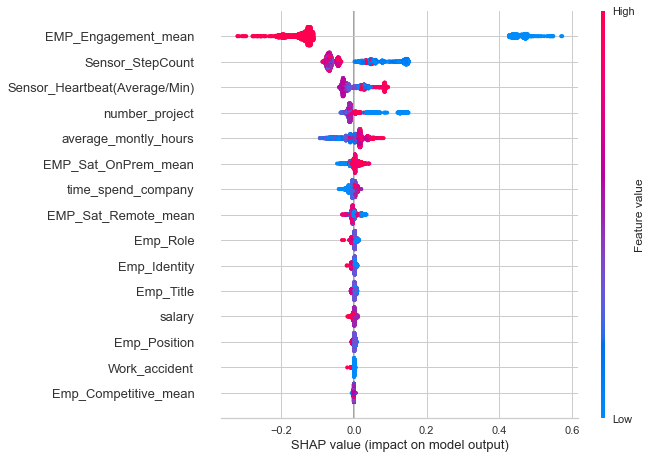

In [78]:
shap.summary_plot(shap_values[1], X_A1_test_shap)

Este gráfico em especial pode ser obtido para cada previsão que o modelo fez. Ou seja, a nível de funcionário eu consigo saber o que levou o modelo a prever a resposta de saída. 
Nesse exemplo, vê-se que as features `EMP_Engagement_mean`, `Sensor_StepCount` e `Sensor_Heartbeat` contribuíram para reduzir a probabilidade de ele se demitir. Em contrapartida a quantidade de horas trabalhadas. `average_montly_hours` contribuiu para essa probabilidade auentar.

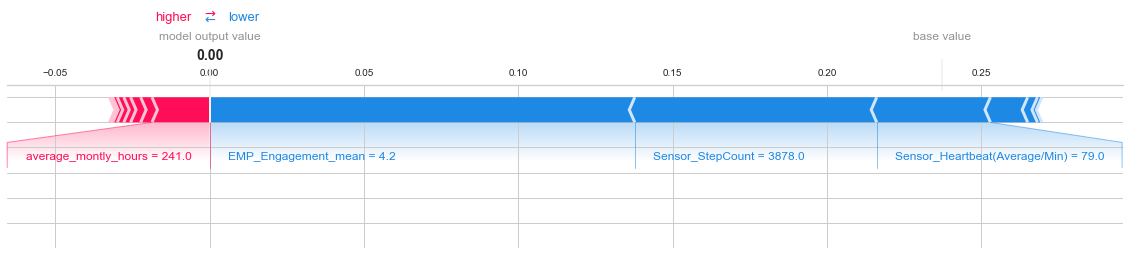

In [83]:
shap.force_plot(explainer_rf.expected_value[1], shap_values[1][14,:], X_A1_test_shap.iloc[14,:], matplotlib = True)


